## 목적
- training 기간이 오래전일 경우 성능의 차이가 있는지?
- 큰 차이가 없다면 매달 모델을 재학습 시킬 필요가 없음
    - 매달 재학습 하는데 cost가 많이 드는가? -> ???
- 몇 개월을 주기로 재학습 하는게 가장 효율적인지? 매달 / 분기별 / 반기별 / 캠페인 시작시 등등

## 설계 - 2가지 방법
1.  train 기간 고정, test 기간 변경
    - train: input(1월), label(2월)
    - test: input(2,3,4,5), label(3,4,5,6)
2.  train 기간 변경, test 기간 고정
    - train: input(1,2,3,4), label(2,3,4,5)
    - test: input(5), label(6)

- split: 8:2
- sampling: 20%
- model: lightgbm
- evaluation: auprc

## 이 페이지 에서는 1번 실험을 다룬다
- different test period

## package

In [47]:
from sklearn.ensemble import RandomForestClassifier
import lightgbm as lgb
import xgboost as xgb

import pandas as pd
import numpy as np
import pickle
import time
import shap
import os
import gc

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [48]:
from sm_utils import sampling, evaluate, show_results, save_model, load_model, make_train_data,  make_test_data

In [49]:
DATA_PATH = '/home/dmig/work/upsell/data/'
RESULT_PATH = '/home/dmig/work/upsell/result/training_preriod/'

## 실험 1
- train 기간 고정, test 기간 변경
- train: input(1월), label(2월)
- test: input(2,3,4,5), label(3,4,5,6)

### TRAIN
- 1월 데이터로 모델 학습

In [52]:
# load data
df_mart01 = pd.read_pickle(os.path.join(DATA_PATH, 'df_mart_201901.pkl'))
df_mart01.shape

(18176215, 81)

In [53]:
# make train data
result = make_train_data(df_mart01)
result.keys()

make_train_data +++
label/sample:  0.2
sample/total:  0.09245956872759263
make_data_for_modeling---


dict_keys(['trn', 'val'])

In [54]:
result['trn'].keys()

dict_keys(['idx', 'x', 'y'])

In [58]:
trn_idx = result['trn']['idx']
x_trn = result['trn']['x']
y_trn = result['trn']['y']


val_idx = result['val']['idx']
x_val = result['val']['x']
y_val = result['val']['y']

trn_idx.shape, x_trn.shape, y_trn.shape, val_idx.shape, x_val.shape, y_val.shape

((1613342, 1),
 (1613342, 79),
 (1613342, 1),
 (403336, 1),
 (403336, 79),
 (403336, 1))

In [59]:
feature_cols = list(trn_x_test.columns)

In [60]:
# parameter
lgb_params = {
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'metric': 'auc',
    'is_unbalance': True,
    'num_leaves': 512,
    'lambda_l1': 3,
    'lambda_l2': 1,
    'learning_rate': 0.05,
    'num_threads': 30,
}

In [61]:
lgb_trn = lgb.Dataset(x_trn, y_trn, feature_name=feature_cols)
lgb_val = lgb.Dataset(x_val, y_val, feature_name=feature_cols)

In [62]:
# modeling
t1 = time.time()
clf = lgb.train(lgb_params,
                train_set=lgb_trn,
                valid_sets=[lgb_trn, lgb_val],
                num_boost_round=2000,
                early_stopping_rounds=100,
                verbose_eval=50)
print('elapsed time:', time.time()-t1)

Training until validation scores don't improve for 100 rounds.
[50]	training's auc: 0.940971	valid_1's auc: 0.937377
[100]	training's auc: 0.956173	valid_1's auc: 0.95162
[150]	training's auc: 0.965032	valid_1's auc: 0.959027
[200]	training's auc: 0.970301	valid_1's auc: 0.962576
[250]	training's auc: 0.973958	valid_1's auc: 0.964387
[300]	training's auc: 0.976504	valid_1's auc: 0.965131
[350]	training's auc: 0.97865	valid_1's auc: 0.965691
[400]	training's auc: 0.980501	valid_1's auc: 0.966144
[450]	training's auc: 0.98212	valid_1's auc: 0.966454
[500]	training's auc: 0.98346	valid_1's auc: 0.966556
[550]	training's auc: 0.984662	valid_1's auc: 0.966708
[600]	training's auc: 0.985754	valid_1's auc: 0.96682
[650]	training's auc: 0.986836	valid_1's auc: 0.967009
[700]	training's auc: 0.987816	valid_1's auc: 0.96714
[750]	training's auc: 0.988682	valid_1's auc: 0.9673
[800]	training's auc: 0.98949	valid_1's auc: 0.967462
[850]	training's auc: 0.99031	valid_1's auc: 0.96763
[900]	training

In [63]:
## save model
save_model(clf, os.path.join(RESULT_PATH, 'model_201901.pkl'))

save model to  /home/dmig/work/upsell/result/training_preriod/model_201901.pkl


### TEST
- 2,3,4,5 데이터로 테스트

In [64]:
test_period_list = ['201902', '201903', '201904', '201905']

In [65]:
def test_different_period(clf, test_ym):
    print('test ym: ', test_ym)
    
    # load data
    print('load data')
    df_mart = pd.read_pickle(os.path.join(DATA_PATH, 'df_mart_{}.pkl'.format(test_ym)))
    print('df_mart: ', df_mart.shape)
    
    # make test data format
    print('make test data format')
    result = make_test_data(df_mart)
    idx = result['idx']
    x_test = result['x']
    y_test = result['y']
    feature_cols = list(x_test.columns)
    print('x_test: ', x_test.shape)
    print('y_test: ', y_test.shape)
    
    # evaluation
    print('evaluation')
    t1 = time.time()
    lgb_result_dict = evaluate(x_test, y_test.label.values, clf, 'lgb')
    print('elapsed time: ', time.time()-t1)

test ym:  201902
load data
df_mart:  (18462905, 81)
make test data format
x_test:  (18462905, 79)
y_test:  (18462905, 1)
evaluation


acc   recall  precision  f1_score       auc
0  0.93824  0.76748   0.262721  0.391444  0.956439

pred: 1   pred: 0
true: 1   366728    111106
true: 0  1029158  16955913

feature   description  importance
44     avg_subscription_period  평균 요금제 변경 주기       75149
5              svc_scrb_period           NaN       71538
49               real_avg_arpu       평균 ARPU       65224
6            last_equip_period           NaN       60402
46             real_arpu_bf_m1       순수 ARPU       44205
48             real_arpu_bf_m3       순수 ARPU       42511
1                          age            나이       42386
3              mng_nice_cb_scr     나이스 신용 점수       39612
47             real_arpu_bf_m2       순수 ARPU       37757
53            data_usage_ratio           NaN       34272
54  bf_m6_data_usage_ratio_avg     데이터 소진 비율       33737
9                  eqp_out_prc        단말 출고가       29996
45            avg_chg_duration      평균 기변 주기       28722
28      data_usage_in_gb_bf_m2     총 데이터 사용량       27229
26      data_usage_in_gb_bf_m0           NaN       26908
27      data_usage_in_gb_bf_m1     총 데이터 사용량       26316
17          avg_twld_visit_cnt  평균 티월드 방문 횟수       21703
7                  bas_fee_amt        요금제 가격       21514
14        twld_visit_cnt_bf_m0           NaN       20010
11               pmth_inv_bamt     전월 잔여 할부금       18936

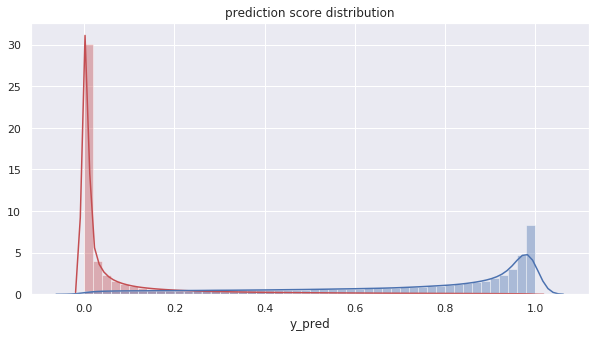

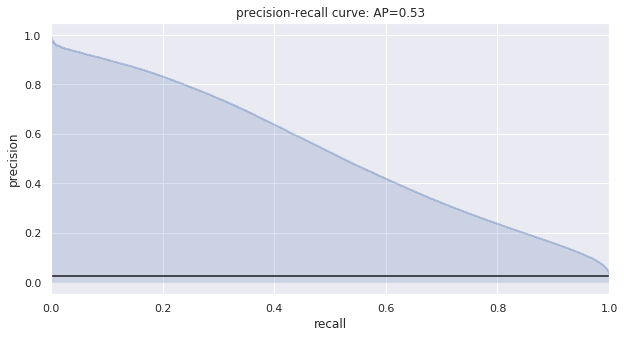

--------------------------------------------------
result dictionary save to /home/dmig/work/upsell/result/_0706_212813.pkl
save model to  /home/dmig/work/upsell/result/_0706_212813.pkl
elapsed time:  467.6122422218323
test ym:  201903
load data
df_mart:  (18580984, 81)
make test data format
x_test:  (18580984, 79)
y_test:  (18580984, 1)
evaluation


acc    recall  precision  f1_score       auc
0  0.938392  0.640641   0.231551  0.340157  0.915276

pred: 1   pred: 0
true: 1   295064    165512
true: 0   979231  17141177

feature   description  importance
44     avg_subscription_period  평균 요금제 변경 주기       75149
5              svc_scrb_period           NaN       71538
49               real_avg_arpu       평균 ARPU       65224
6            last_equip_period           NaN       60402
46             real_arpu_bf_m1       순수 ARPU       44205
48             real_arpu_bf_m3       순수 ARPU       42511
1                          age            나이       42386
3              mng_nice_cb_scr     나이스 신용 점수       39612
47             real_arpu_bf_m2       순수 ARPU       37757
53            data_usage_ratio           NaN       34272
54  bf_m6_data_usage_ratio_avg     데이터 소진 비율       33737
9                  eqp_out_prc        단말 출고가       29996
45            avg_chg_duration      평균 기변 주기       28722
28      data_usage_in_gb_bf_m2     총 데이터 사용량       27229
26      data_usage_in_gb_bf_m0           NaN       26908
27      data_usage_in_gb_bf_m1     총 데이터 사용량       26316
17          avg_twld_visit_cnt  평균 티월드 방문 횟수       21703
7                  bas_fee_amt        요금제 가격       21514
14        twld_visit_cnt_bf_m0           NaN       20010
11               pmth_inv_bamt     전월 잔여 할부금       18936

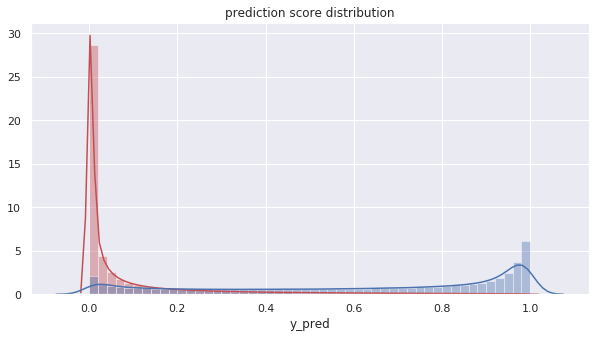

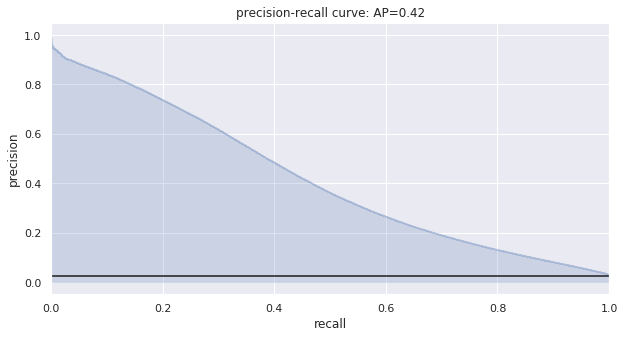

--------------------------------------------------
result dictionary save to /home/dmig/work/upsell/result/_0706_213635.pkl
save model to  /home/dmig/work/upsell/result/_0706_213635.pkl
elapsed time:  480.009489774704
test ym:  201904
load data
df_mart:  (18626176, 81)
make test data format
x_test:  (18626176, 79)
y_test:  (18626176, 1)
evaluation


acc    recall  precision  f1_score       auc
0  0.930849  0.525431   0.203882  0.293772  0.865778

pred: 1   pred: 0
true: 1   267890    241958
true: 0  1046057  17070271

feature   description  importance
44     avg_subscription_period  평균 요금제 변경 주기       75149
5              svc_scrb_period           NaN       71538
49               real_avg_arpu       평균 ARPU       65224
6            last_equip_period           NaN       60402
46             real_arpu_bf_m1       순수 ARPU       44205
48             real_arpu_bf_m3       순수 ARPU       42511
1                          age            나이       42386
3              mng_nice_cb_scr     나이스 신용 점수       39612
47             real_arpu_bf_m2       순수 ARPU       37757
53            data_usage_ratio           NaN       34272
54  bf_m6_data_usage_ratio_avg     데이터 소진 비율       33737
9                  eqp_out_prc        단말 출고가       29996
45            avg_chg_duration      평균 기변 주기       28722
28      data_usage_in_gb_bf_m2     총 데이터 사용량       27229
26      data_usage_in_gb_bf_m0           NaN       26908
27      data_usage_in_gb_bf_m1     총 데이터 사용량       26316
17          avg_twld_visit_cnt  평균 티월드 방문 횟수       21703
7                  bas_fee_amt        요금제 가격       21514
14        twld_visit_cnt_bf_m0           NaN       20010
11               pmth_inv_bamt     전월 잔여 할부금       18936

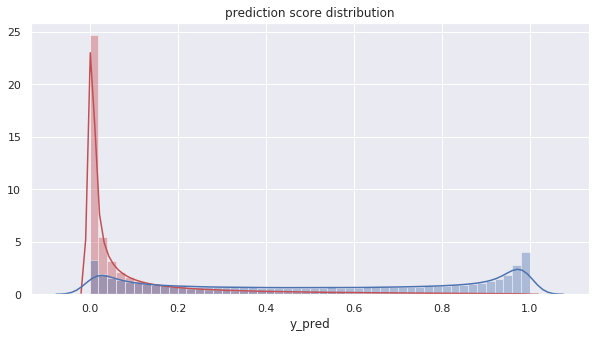

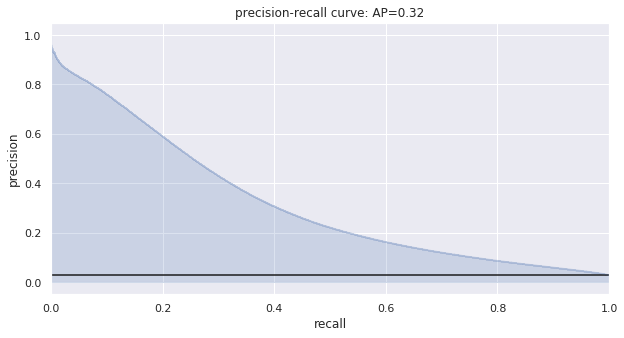

--------------------------------------------------
result dictionary save to /home/dmig/work/upsell/result/_0706_214523.pkl
save model to  /home/dmig/work/upsell/result/_0706_214523.pkl
elapsed time:  497.97445821762085
test ym:  201905
load data
df_mart:  (18707537, 81)
make test data format
x_test:  (18707537, 79)
y_test:  (18707537, 1)
evaluation


acc    recall  precision  f1_score       auc
0  0.723645  0.448317   0.038141    0.0703  0.643686

pred: 1   pred: 0
true: 1   195465    240532
true: 0  4929389  13342151

feature   description  importance
44     avg_subscription_period  평균 요금제 변경 주기       75149
5              svc_scrb_period           NaN       71538
49               real_avg_arpu       평균 ARPU       65224
6            last_equip_period           NaN       60402
46             real_arpu_bf_m1       순수 ARPU       44205
48             real_arpu_bf_m3       순수 ARPU       42511
1                          age            나이       42386
3              mng_nice_cb_scr     나이스 신용 점수       39612
47             real_arpu_bf_m2       순수 ARPU       37757
53            data_usage_ratio           NaN       34272
54  bf_m6_data_usage_ratio_avg     데이터 소진 비율       33737
9                  eqp_out_prc        단말 출고가       29996
45            avg_chg_duration      평균 기변 주기       28722
28      data_usage_in_gb_bf_m2     총 데이터 사용량       27229
26      data_usage_in_gb_bf_m0           NaN       26908
27      data_usage_in_gb_bf_m1     총 데이터 사용량       26316
17          avg_twld_visit_cnt  평균 티월드 방문 횟수       21703
7                  bas_fee_amt        요금제 가격       21514
14        twld_visit_cnt_bf_m0           NaN       20010
11               pmth_inv_bamt     전월 잔여 할부금       18936

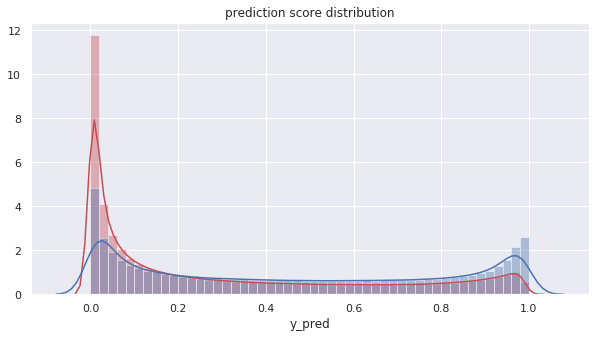

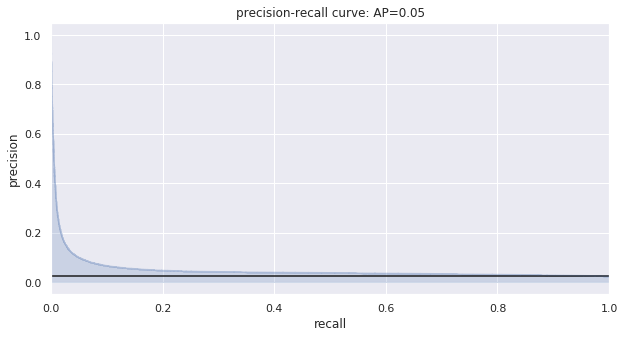

--------------------------------------------------
result dictionary save to /home/dmig/work/upsell/result/_0706_215416.pkl
save model to  /home/dmig/work/upsell/result/_0706_215416.pkl
elapsed time:  500.64888215065


In [66]:
for p in test_period_list:
    test_different_period(clf, p)

## 결과
- 테스트 기간이 멀어질 수록 성능이 낮아짐(0.53->0.42->0.32->0.05...)
- 이후로는 모델을 최신 데이터로 재학습 해야함

## TODO
- 5월 테스트 데이터의 경우 성능이 너무 낮음, 더 살펴볼 필요가 있음